In [ ]:
import pandas as pd
from google.colab import drive
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
drive.mount('/content/drive')

import statsmodels.api as sm
import statsmodels.formula.api as smf

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Este trabajo abordará sobre un dataset de autos. Este dataset proviene de Alemania.

https://www.zenrows.com/datasets/germany-cars

Cuenta con información como kilometraje, modelo, tipo de combustible, tipo de transmisión, precio, caballos de fuerza, uso y año.

El objetivo del trabajo como una primera parte es explorar y analizar el comportamiento de cada variable, y estudiar las posibles relaciones que guardan entre ellas.
El objetivo final del trabajo es crear un modelo para predecir qué precio tendrá un automovil dado sus características

In [ ]:
# Cargamos los datos
data = pd.read_csv('/content/drive/MyDrive/Fundamentos de Ciencias de Datos/TPFinal/germany-cars-zenrows.csv')

print('Cantidad de registros: ' + str(len(data)))
data.drop(columns=['make','model'], inplace=True)
data

Cantidad de registros: 46405


,mileage,fuel,gear,offerType,price,hp,year
0,235000,Diesel,Manual,Used,6800,116.0,2011
1,92800,Gasoline,Manual,Used,6877,122.0,2011
2,149300,Gasoline,Manual,Used,6900,160.0,2011
3,96200,Gasoline,Manual,Used,6950,110.0,2011
4,156000,Gasoline,Manual,Used,6950,156.0,2011
...,...,...,...,...,...,...,...
46400,99,Electric/Gasoline,Manual,Pre-registered,12990,71.0,2021
46401,99,Electric/Gasoline,Manual,Pre-registered,12990,71.0,2021
46402,99,Electric/Gasoline,Manual,Pre-registered,12990,71.0,2021
46403,99,Electric/Gasoline,Manual,Pre-registered,12990,71.0,2021


#Descripción general de las variables:

- Mileage: Cantidad de kilometros recorridos. Valor entero, contínua.
- Make: Marca del auto. String, categórica nominal.
- Model: Modelo del auto. String, categórica nominal.
- Fuel: Tipo de combustible. String, categórica nominal.
- Gear: Tipo de transmisión. String, categórica nominal.
- offerType: Estado del auto (usado). String, categórica nominal.
- Price: Precio del auto, expresado en euros. Entero, contínua.
- HP: Caballos de fuerza. Float, contínua.
- Year: Año del vehículo. Entero, categórica ordinal.

In [ ]:
# Chequear valores nulos
print('Valores nulos')
for column in list(data.columns):
  print(column + ': ' + str(data['mileage'].isna().sum()))

# Concluímos de aquí que el dataset no tiene valores faltantes

Valores nulos
mileage: 0
make: 0
model: 0
fuel: 0
gear: 0
offerType: 0
price: 0
hp: 0
year: 0


Text(0.5, 1.0, 'Histograma de Kilometraje')

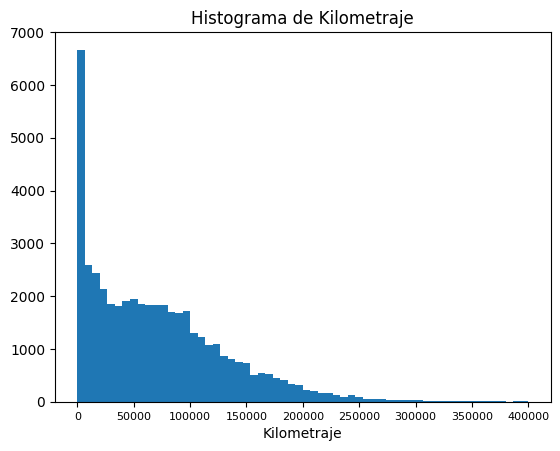

In [ ]:
# Explorar las columnas
# Primera columna: mileage. Representa el kilometraje de cada vehículo
values_mileage = data['mileage'].values

plt.hist(values_mileage, bins=60, range=(0,400000))
plt.ticklabel_format(style='plain')
plt.xticks(fontsize=8)
plt.xlabel('Kilometraje')
plt.title('Histograma de Kilometraje')




Text(0.5, 1.0, 'Frecuencia suavizada del kilometraje')

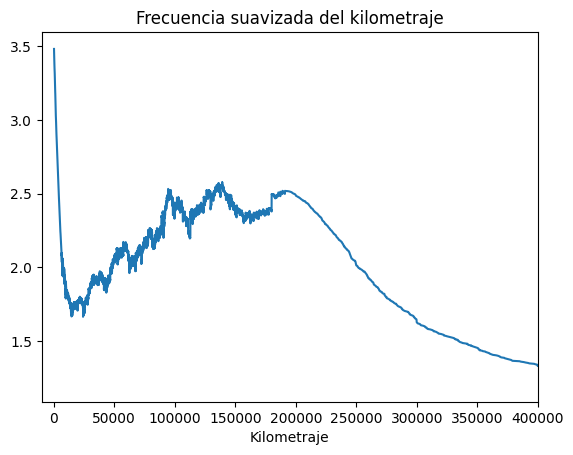

In [ ]:
# Suavizar el gráfico anterior
# Savitzky-Golay propone aproximar mediante un polinomio, en lugar de los kernels que nos enseñaron
from scipy.signal import savgol_filter
from statsmodels.nonparametric.smoothers_lowess import lowess

frequency = data['mileage'].value_counts().sort_index() #.rolling(window=20, win_type='gaussian', center=True).mean(std=2)
frequency_aux = frequency[100::]
smooth_frequency = savgol_filter(frequency_aux, window_length=2000, polyorder=3)


plt.plot(frequency_aux.index, smooth_frequency)
plt.ticklabel_format(style='plain')
plt.xlim(-10000,400000)
plt.xlabel('Kilometraje')
plt.title('Frecuencia suavizada del kilometraje')

Podemos concluir de la columna kilometraje que hay una gran cantidad de autos cero kilómetro, y luego se observa una clase de campana, centrada alrededor de los 150000 kilometros.
No se deciden dar indicadores estadísticos como la media ya que la muestra cuenta con una gran varianza.

Text(0.5, 0, 'Marca')

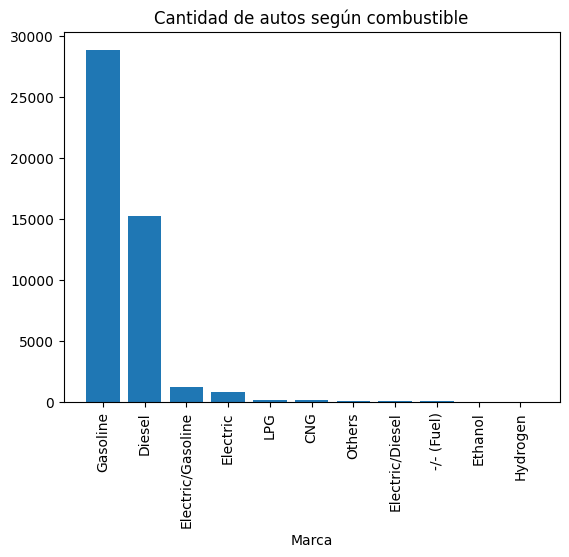

In [ ]:
# No nos interesa explorar las columnas make y model, así que por ahora las ignoramos. Más adelante podemos responder la pregunta de cuáles son los autos más vendidos
# Columna fuel
data.fuel.unique()
data_fuel = data['fuel'].value_counts()
data_fuel
plt.bar(data_fuel.index, data_fuel.values)
plt.xticks(rotation=90)
plt.title('Cantidad de autos según combustible')
plt.xlabel('Marca')


Text(0.5, 0, 'Tipo de combustible')

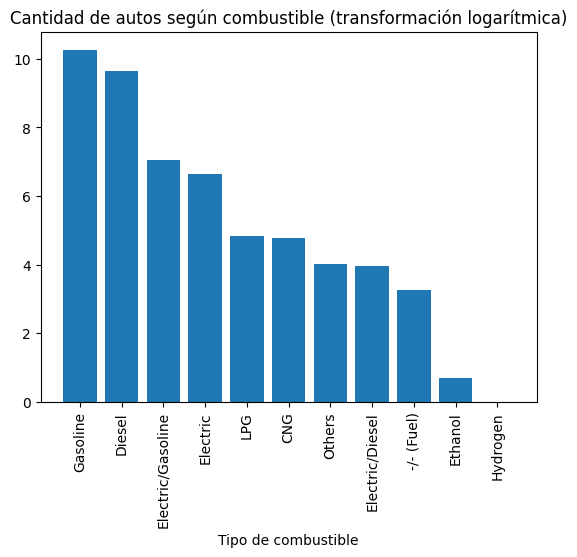

In [ ]:
# Transformación logarítmica: Necesitamos ajustar la escala para visualizar mejor los valores más bajos
fuel_groupby = data['fuel'].groupby(data['fuel']).count()
fuel_groupby_log = fuel_groupby.apply(lambda x: np.log(x)).sort_values(ascending=False)
plt.bar(fuel_groupby_log.index, fuel_groupby_log.values)
plt.xticks(rotation=90)
plt.title('Cantidad de autos según combustible (transformación logarítmica)')
plt.xlabel('Tipo de combustible')

Concluimos que casi todos los autos son a gasolina o a diesel, siguiendoles los electricos.


Text(0.5, 0, 'Tipo de transmisión')

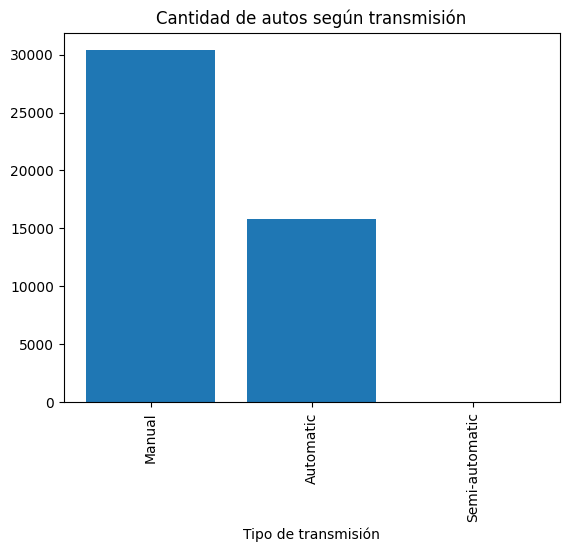

In [ ]:
# Columna marcha (gear)
data['gear'].unique()
data_gear = data['gear'].value_counts()
data_gear
plt.bar(data_gear.index, data_gear.values)
plt.xticks(rotation=90)
plt.title('Cantidad de autos según transmisión')
plt.xlabel('Tipo de transmisión')

Text(0.5, 1.0, 'Porcentaje de transmisión de autos')

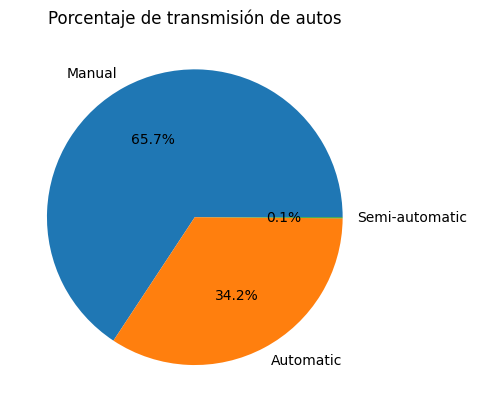

In [ ]:
# Gráfico de torta
plt.pie(data_gear, labels=data_gear.index, autopct='%1.1f%%')
plt.title('Porcentaje de transmisión de autos')

Concluímos que alrededor de dos tercios de los autos tiene transmisión manual, mientras que el otro tercio tiene transmisión automática. Casi ninguno tiene transmisión semi automática.


Text(0.5, 0, 'Estado del auto')

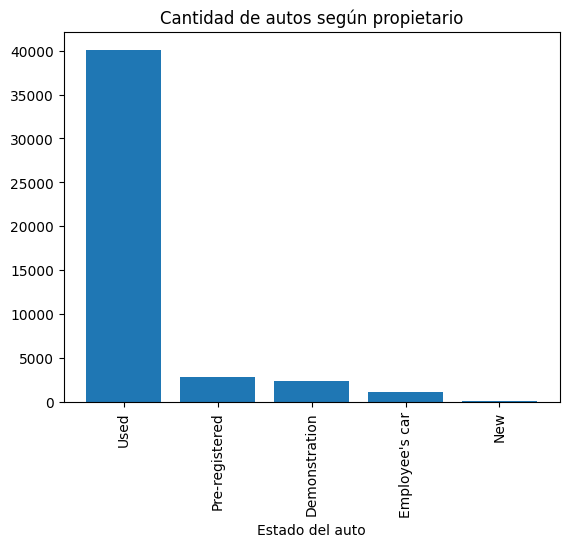

In [ ]:
# Columna offerType
# Esta columna indica si el auto es usado, nuevo, etc.
data['offerType'].unique()
data_offer = data['offerType'].value_counts()
data_offer
plt.bar(data_offer.index, data_offer.values)
plt.xticks(rotation=90)
plt.title('Cantidad de autos según propietario')
plt.xlabel('Estado del auto')

Text(0.5, 1.0, 'Porcentaje de estado del auto')

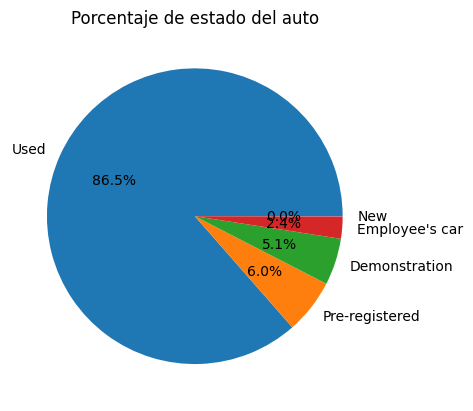

In [ ]:
plt.pie(data_offer, labels=data_offer.index, autopct='%1.1f%%')
plt.title('Porcentaje de estado del auto')

Vemos que la mayoría de autos son usados, mientras que existen alrededor de un 14% de otras categorías. Sorprendentemente, a pesar de que existen muchísimos autos con poco o nulo kilometraje, pocos figuran como 'nuevo'


In [ ]:
# Columna precio.
# Precio del auto.
# Indicadores estadísticos
media = data['price'].mean()
desvio = data['price'].std()
coef_var = desvio / media
mad = data['price'].mad()
print('Medidas estadísticas de la columna de precios')
print('Media: ' + str(media))
print('Desvío estándar: ' + str(desvio))
print('Coeficiente de variación: ' + str(coef_var))
print('Mean Absolute Deviation (MAD): ' + str(mad))

Medidas estadísticas de la columna de precios
Media: 16572.33722659196
Desvío estándar: 19304.6959239994
Coeficiente de variación: 1.1648746739852178
Mean Absolute Deviation (MAD): 10314.429430375652


<ipython-input-125-80317319a0bf>:7: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  mad = data['price'].mad()


In [ ]:
data['price'].value_counts()

7990      451
6990      434
8990      417
5990      413
9990      403
         ... 
16439       1
2895        1
3895        1
135007      1
88960       1
Name: price, Length: 6668, dtype: int64

Text(0.5, 0, 'Precio')

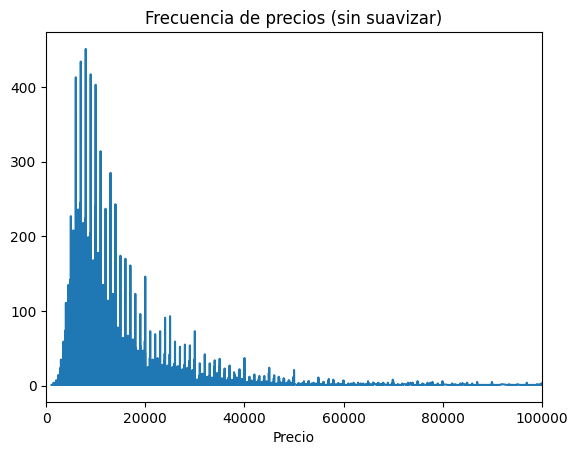

In [ ]:
# Visualizar precios
frequency_price = data['price'].value_counts().sort_index()
plt.plot(frequency_price.index, frequency_price.values)
plt.xlim(0,100000)
plt.title('Frecuencia de precios (sin suavizar)')
plt.xlabel('Precio')

Text(0.5, 1.0, 'Frecuencia de precios')

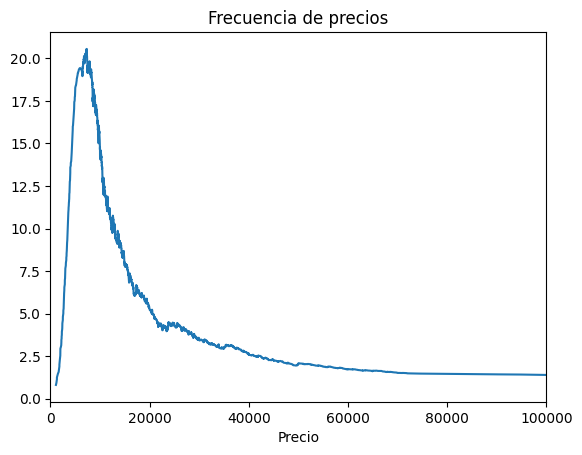

In [ ]:
# Suavizado usando kernels ( exponencial simple)
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.api import ExponentialSmoothing
from scipy.signal import savgol_filter

# Suavizado exponencial
#model = ExponentialSmoothing(frequency_price, trend='add', seasonal='add', seasonal_periods=3).fit(smoothing_level=0.3, smoothing_trend=0.1, smoothing_seasonal=0.1)
#model.fittedvalues.plot()
#plt.xlim(0,100000)

#frequency_price_smooth = frequency_price#.rolling(window=100).mean()
#plt.plot(frequency_price.index, frequency_price_smooth)
#plt.xlim(0,100000)

# No sirvieron los suavizados exponenciales, usar el de polinomios.
smooth_price = savgol_filter(frequency_price, window_length=1000, polyorder=3)
plt.plot(frequency_price.index, smooth_price)

plt.xlim(0,100000)
plt.xlabel('Precio')
plt.title('Frecuencia de precios')

¡Interesante! Se puede ver que la distribución de precios tiene una distribución chi cuadrado. Al analizar valores tales como precios, o ingresos, estos suelen tener esta distribución.

([<matplotlib.axis.XTick at 0x7fd5f733ece0>,
 [Text(0.0, 0, '0'),
  Text(7490.0, 0, '7490'),
  Text(10999.0, 0, '10999'),
  Text(19490.0, 0, '19490'),
  Text(40000.0, 0, '40000'),
  Text(60000.0, 0, '60000'),
  Text(80000.0, 0, '80000'),
  Text(100000.0, 0, '100000')])

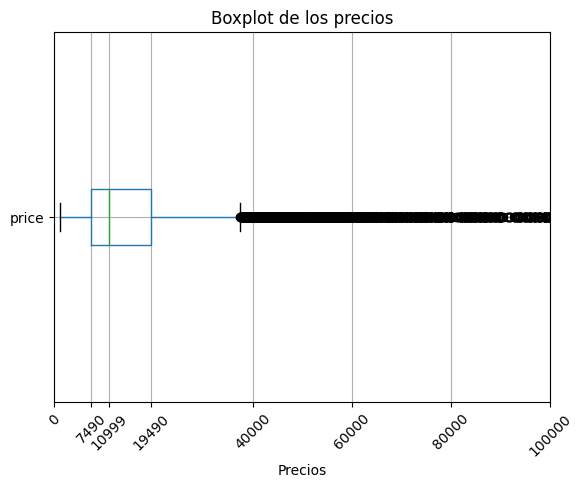

In [ ]:
# Ver en un boxplot
data.boxplot(column='price', vert=False)
price_Q1 = data['price'].quantile(0.25)
price_Q3 = data['price'].quantile(0.75)
price_median = data['price'].median()
plt.xlim(0,100000)
plt.title('Boxplot de los precios')
plt.xlabel('Precios')
tick_positions = [0,price_Q1,price_median,price_Q3,40000,60000,80000,100000]
tick_label = ['0',str(int(price_Q1)),str(int(price_median)),str(int(price_Q3)),'40000','60000','80000','100000']
plt.xticks(tick_positions, tick_label, rotation=45)

Aquí podemos visualizar mejor los indicadores estadísticos
Alrededor de 40000, vemos que se encuentra el valor máximo, habiendo a su derecha valores atípicos. El cuartil 1 se encuentra en 7490, lo que significa que el 25% de los autos se venden a menos de 7490 euros, la mediana es 10999, y el cuartil 3 es 19490.

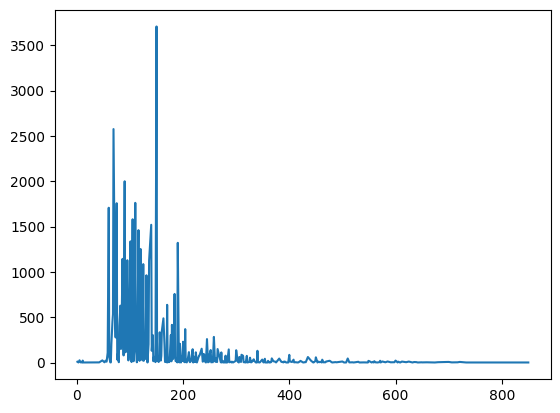

In [ ]:
# El resto de columnas no es de gran interés analizar. Mostraremos nomás las distribuciones de dichas columnas
frequency_hp = data['hp'].value_counts().sort_index()

frequency_hp_smooth = savgol_filter(frequency_hp, window_length=50, polyorder=3)
plt.plot(frequency_hp.index, frequency_hp.values)

Moda: 0    150.0
Name: hp, dtype: float64


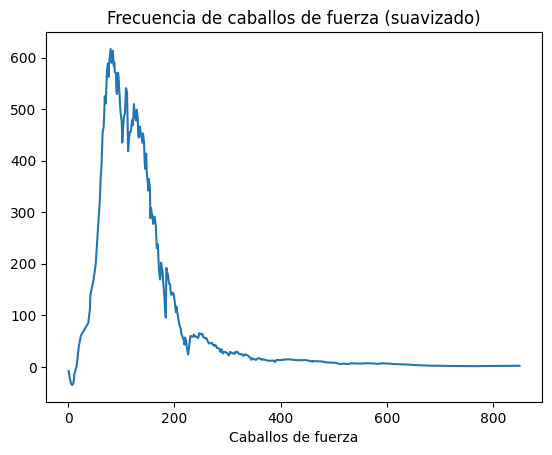

In [ ]:
# Suavizado
plt.plot(frequency_hp.index, frequency_hp_smooth)
plt.title('Frecuencia de caballos de fuerza (suavizado)')
plt.xlabel('Caballos de fuerza')

print('Moda: ' + str(data['hp'].mode()))


#Nuevamente podemos observar que la distribución se asemeja a una chi cuadrado. Algo que resaltar es la moda, que indica que un valor popular son los 150 caballos de fuerza.

(3000.0, 5000.0)

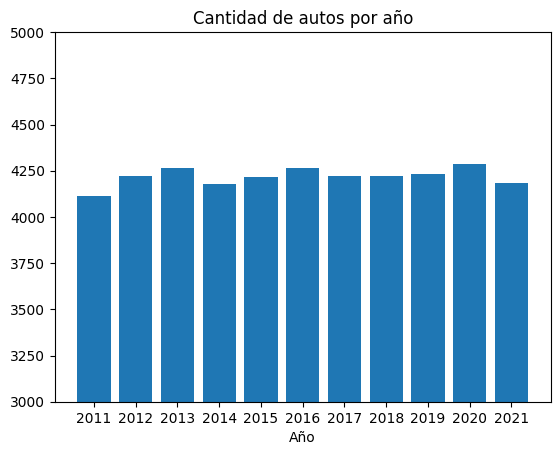

In [ ]:
# Columna año.
# Histograma para visualizar la frecuencia según año del vehículo
frequency_year = data['year'].value_counts().sort_index()
plt.bar(frequency_year.index, frequency_year.values)
plt.title('Cantidad de autos por año')
plt.xlabel('Año')
years = [year for year in range(2011,2022)]
plt.xticks(years)
plt.ylim(3000,5000)

Al parecer, se distribuyen de manera uniforme. No es de interés analizar esta columna más a fondo

# Segunda parte: Hallar correlaciones


In [ ]:
# Usar un heatmap para visualizar relaciones
matrix_corr = data.corr()
matrix_corr_spearman = data.corr(method='spearman')
matrix_corr
# Primero procedemos a visualizar correlaciones entre las variables contínuas, luego veremos que sucede con las categóricas (dificultad, ya que son todas nominales)



<ipython-input-37-93bc569c241b>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  matrix_corr = data.corr()
<ipython-input-37-93bc569c241b>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  matrix_corr_spearman = data.corr(method='spearman')


,mileage,price,hp,year
mileage,1.000000,-0.302788,-0.015086,-0.676131
price,-0.302788,1.000000,0.747617,0.405633
hp,-0.015086,0.747617,1.000000,0.167232
year,-0.676131,0.405633,0.167232,1.000000


Text(0.5, 1.0, 'Heatmap de correlación (variables contínuas)')

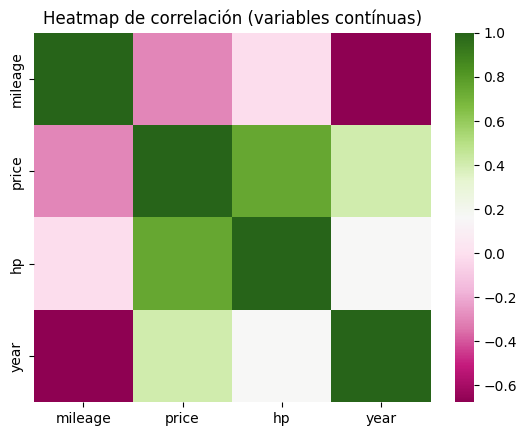

In [ ]:
# Matriz de correlación
sns.heatmap(matrix_corr, cmap='PiYG')
plt.title('Heatmap de correlación (variables contínuas)')

Se nota una correlación grande entre precio y caballos de fuerza, mientras que una gran correlación negativa entre kilometraje y año.
Por otro lado, existe una correlación cercana a cero entre caballos de fuerza y año
Veamos ahora las correlaciones en scatter plots.


Text(0.5, 1.0, 'Heatmap de correlación de Spearman (variables contínuas)')

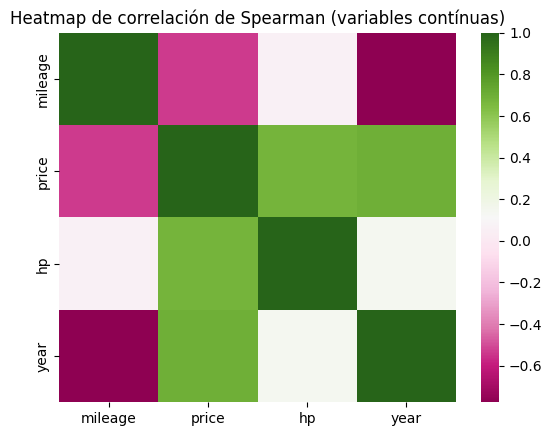

In [ ]:
# Matriz de correlación de Spearman
# Para ver si existe una relación monotónica
sns.heatmap(matrix_corr_spearman, cmap='PiYG')
plt.title('Heatmap de correlación de Spearman (variables contínuas)')

Vemos que se pronuncian los pares Precio-Año y Precio-Kilometraje, lo que indica que tal vez tengan una relación no lineal.


(-50000.0, 600000.0)

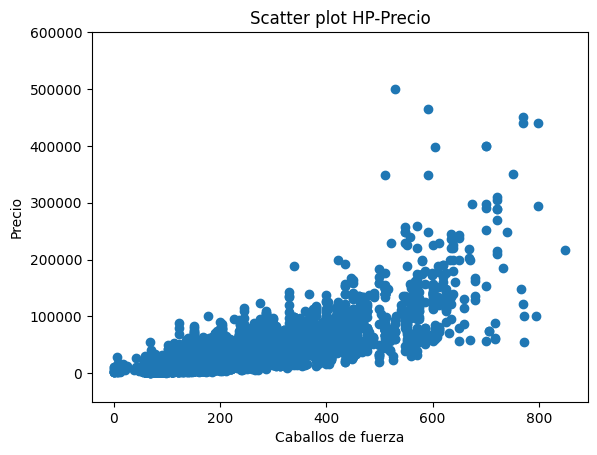

In [ ]:
#HP-Precio
plt.scatter(data['hp'].values,data['price'].values)
plt.ticklabel_format(style='plain')
plt.xlabel('Caballos de fuerza')
plt.ylabel('Precio')
plt.title('Scatter plot HP-Precio')
plt.ylim(-50000,600000)

Se observa una tendencia entre los caballos de fuerza y el precio: a mayor caballos de fuerza, mayor el precio.

Text(0.5, 1.0, 'Boxplot agrupado Año-Kilometraje')

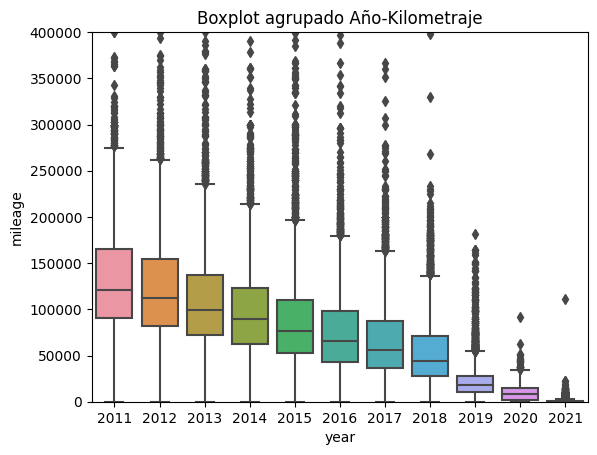

In [ ]:
sns.boxplot(x='year', y='mileage', data=data)
plt.ylim(0,400000)
plt.title('Boxplot agrupado Año-Kilometraje')

Este gráfico nos sirve para observar la tendencia descendiente que tiene el kilometraje respecto a los años. ¿Transformación logarítmica?

(0.0, 600000.0)

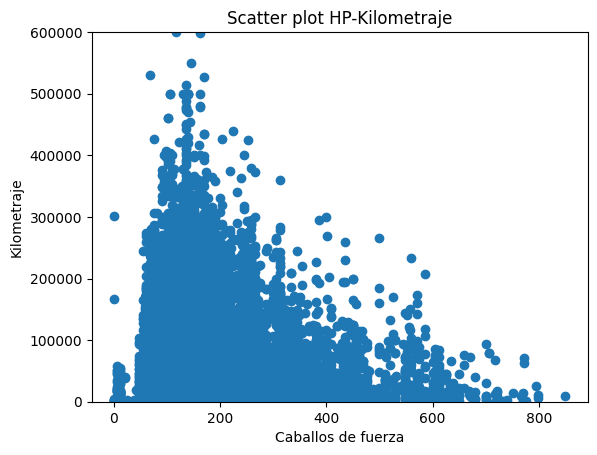

In [ ]:
# Caballos de fuerza - Kilometraje
plt.scatter(data['hp'].values,data['mileage'].values)
plt.ticklabel_format(style='plain')
plt.xlabel('Caballos de fuerza')
plt.ylabel('Kilometraje')
plt.title('Scatter plot HP-Kilometraje')
plt.ylim(0,600000)

# No se observa nada, o al menos yo no observo

La correlación es casi nula, sin embargo se decide visualizar ya que
$Cov(X,Y) = 0 \nRightarrow X \text{ e } Y \text{ son independientes}$

Es posible que se pueda observar que a medida de que tengan más caballos de fuerza, no sea posible que tengan alto kilometraje.


(-50000.0, 800000.0)

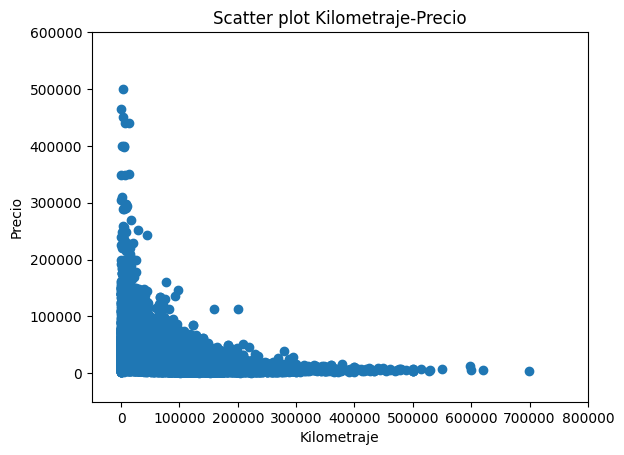

In [ ]:
# Proponer usar transformación logarítmica
data['log_mileage'] = data['mileage'].apply(lambda x: np.log(x))

#Precio-Kilometraje
plt.scatter(data['mileage'].values,data['price'].values)
plt.ticklabel_format(style='plain')
plt.xlabel('Kilometraje')
plt.ylabel('Precio')
plt.title('Scatter plot Kilometraje-Precio')
plt.ylim(-50000,600000)
plt.xlim(-50000,800000)

Se observa una relación inversamente proporcional entre el precio y el kilometraje

Text(0.5, 1.0, 'Boxplot agrupado Año-Precio')

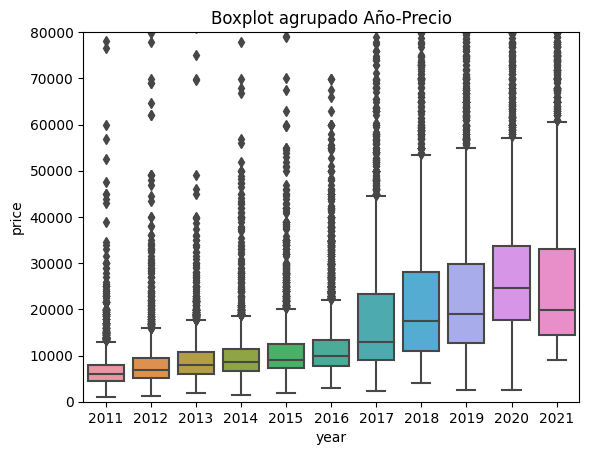

In [ ]:
#Precio-Año
sns.boxplot(x='year', y='price', data=data)
plt.ylim(0,80000)
plt.title('Boxplot agrupado Año-Precio')

Podemos observar una relacion entre el año y el precio, autos más nuevos son más caros.

#SEGUNDA PARTE: REGRESIÓN LINEAL
Concluimos que nuestra variable de interés a analizar es la de precios.
Decidimos tomar como variables dependientes: mileage, gear, fuel, offertype, hp y year.
Separamos por tres categorías de variables: variables contínuas, categóricas nominales y categóricas ordinales
- Contínuas: mileage, hp.
- Categóricas nominales: fuel, gear, offertype.
- Categóricas ordinales: year.


In [ ]:
# Categóricas:

data_dummies = pd.get_dummies(data, ['fuel', 'gear', 'offerType'], drop_first = False)

# Dropeamos manualmente así tomamos como base una categoría significativa
# Uso del auto: dropeamos New, asi comparamos respecto a qué uso tuvo comparado con el mismo auto nuevo
# Transmisión: dropeamos Manual, así comparamos respecto de una categoría común, y entendible
data_dummies.drop(['fuel_-/- (Fuel)','gear_Manual','offerType_New'], axis = 1, inplace=True)


# Contínuas, categóricas ordinales:
# mileage, hp, year:
# Estas columnas no requieren tratamiento

# Dropear nan de data_dummies
data_dummies = data_dummies.dropna(how='any')

data_dummies.head(1)
data_dummies.columns

Index(['mileage', 'price', 'hp', 'year', 'fuel_CNG', 'fuel_Diesel',
       'fuel_Electric', 'fuel_Electric/Diesel', 'fuel_Electric/Gasoline',
       'fuel_Ethanol', 'fuel_Gasoline', 'fuel_Hydrogen', 'fuel_LPG',
       'fuel_Others', 'gear_Automatic', 'gear_Semi-automatic',
       'offerType_Demonstration', 'offerType_Employee's car',
       'offerType_Pre-registered', 'offerType_Used'],
      dtype='object')

# Creación del modelo
Usando la librería statsmodels, procedemos a crear el modelo
Para el modelo, se establece como variable independiente a price.
Como variable dependiente, se incluyen todas las demás que tratamos anteriormente.

In [ ]:
# Seleccionamos todas las columnas variables independentes
data_dummies.columns = data_dummies.columns.str.replace('[^a-zA-Z0-9_]', '')

feature_columns = data_dummies.columns.drop('price')
formula = 'price ~ ' + ' + '.join(feature_columns)

model = smf.ols(formula=formula, data=data_dummies)
model_fit1 = model.fit()
print(model_fit1.summary())

<ipython-input-8-886d5c229b01>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  data_dummies.columns = data_dummies.columns.str.replace('[^a-zA-Z0-9_]', '')


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     4786.
Date:                Fri, 07 Jul 2023   Prob (F-statistic):               0.00
Time:                        19:13:00   Log-Likelihood:            -4.9828e+05
No. Observations:               46376   AIC:                         9.966e+05
Df Residuals:                   46356   BIC:                         9.968e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept               -1

Para una mejor interpretación de los valores del modelo, se debe estandarizar las variables.

Un método que se suele usar comúnmente es la estandarización con el método de puntaje z, sin embargo, debido a que se cuentan con una gran cantidad de registros, y al haber muchísimos outliers, se decide optar por otro método.

Por esto, se decide por el escalado robusto

De esta manera, se cuenta con una escala común, todas las variables tienen una influencia similar en el modelo

In [ ]:
from sklearn.preprocessing import RobustScaler
# Creamos la instancia RobustScaler
scaler = RobustScaler()

columnas_continuas = ['mileage', 'hp', 'year', 'price']

# Estandarizamos los datos
data_dummies[columnas_continuas] = scaler.fit_transform(data_dummies[columnas_continuas])


In [ ]:
# Ahora, veamos el modelo
data_dummies.columns = data_dummies.columns.str.replace('[^a-zA-Z0-9_]', '')

feature_columns = data_dummies.columns.drop('price')
formula = 'price ~ ' + ' + '.join(feature_columns)

model = smf.ols(formula=formula, data=data_dummies)
model_fit = model.fit()
print(model_fit.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     4786.
Date:                Wed, 05 Jul 2023   Prob (F-statistic):               0.00
Time:                        22:10:40   Log-Likelihood:                -62687.
No. Observations:               46376   AIC:                         1.254e+05
Df Residuals:                   46356   BIC:                         1.256e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

<ipython-input-131-54b739103b83>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  data_dummies.columns = data_dummies.columns.str.replace('[^a-zA-Z0-9_]', '')


Analizando los valores al incluir todas las columnas como variables independientes vemos que:

- R² y R² ajustado: Un valor del 66% indica que alrededor de un 66% de la variación en la variable dependiente (precio) puede ser explicada mediante las variables independientes. El modelo es razonablemente preciso.

- Coeficientes, p-values y t-values: Los coeficientes indican la magnitud y dirección de la relación entre la variable dependiente y la independiente a analizar, mientras que el p-value sirve de un indicador estadístico de la significancia de dicho coeficiente. Tomamos como umbral un valor de 0.05 para el p-value y un valor de [-2,2] para el t-value. Veamos estos valores para cada una de las variables:
-- mileage: Coeficiente sin estandarizar: -0,06, esto indica que por cada kilómetro que tiene el auto, el precio baja 6 céntimos de euro. Su p-value de 0 indica que el kilometraje es estadísticamente significativa. Su t value (división entre el coeficiente y el error estándar) en el modelo estandarizado es alto (-46), lo que afirma la significancia de esta variable.
-- hp: Coeficiente sin estandarizar: 182, esto indica que por cada caballo de fuerza de más que tiene un auto, el precio sube 182 euros. Su p-value de 0 indica que es estadísticamente significativa. su t value en el modelo estandarizado es muy alto (221), lo que afirma la significancia de esta variable.
-- year: Coeficiente sin estandarizar: 808, esto indica que por cada año de más que tiene un auto, el precio aumenta en 808 euros. Su p-value de 0 indica que es estadísticamente significativa. Su t value es alto (30), lo que afirma la significancia de esta variable.
-- fuel: La mayoría de combustibles tienen p-values altos, esto indica que los combustibles no tienen un impacto significativo en el precio. Tiene sentido considerar un modelo quitando estas categorías. Lo que podríamos hacer, es incluir solo Eléctrico, ya que este tiene un p-value razonable, y analizar el valor que agrega que el combustible sea electrico.
-- gear: Dropeando transmisión manual, vemos que la automática tiene un p-value bajo, lo que indica que la transmisión es significativa para el modelo. Semiautomático tiene un p-value muy alto, lo que hace que no explique bien el modelo. Dado que la cantidad de autos que tienen transmisión semiautomático es muy baja (56 entre 46405), resulta razonable dropear estos registros, y refinar el modelo. El coeficiente indica que si el auto es automático en lugar de manual, el precio disminuye 431 euros.
-- offerType: Todos los tipos de ofertas son similares respecto a sus p-values y t-values, tienen 'buenos' valores, incluso sus coeficientes son similares. En general, cuando un auto no es nuevo, su precio se reduce en más de 20000 euros

# ¡Mejoremos el modelo!
Entonces, mantenemos únicamente el tipo de combustible eléctrico y dropeamos los registros correspondientes a la transmisión semiautomática.

In [ ]:
# Dropear registros
data_without_semiautomatic = data[data['gear'] != 'Semi-automatic'].dropna(how='any')

# Dropear columnas

data_dummies_w_semi = pd.get_dummies(data_without_semiautomatic, ['fuel', 'gear', 'offerType'], drop_first = False)

#data_dummies_w_semi.columns

data_dummies_w_semi.drop(['fuel_-/- (Fuel)', 'fuel_CNG','fuel_Electric/Diesel',
       'fuel_Electric/Gasoline', 'fuel_Ethanol','fuel_Gasoline',
       'fuel_Hydrogen', 'fuel_LPG', 'fuel_Others', 'gear_Automatic','offerType_New', 'fuel_Diesel'], axis = 1, inplace=True)

# Creamos nuevamente el modelo
# Sin estandarizado
data_dummies_w_semi.columns = data_dummies_w_semi.columns.str.replace('[^a-zA-Z0-9_]', '')

feature_columns = data_dummies_w_semi.columns.drop('price')
formula = 'price ~ ' + ' + '.join(feature_columns)

model = smf.ols(formula=formula, data=data_dummies_w_semi)
model_fit2 = model.fit()
print(model_fit2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                 1.002e+04
Date:                Wed, 05 Jul 2023   Prob (F-statistic):               0.00
Time:                        22:11:13   Log-Likelihood:            -4.9588e+05
No. Observations:               46141   AIC:                         9.918e+05
Df Residuals:                   46131   BIC:                         9.919e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept               -1

<ipython-input-132-7be4eeb69ce0>:16: FutureWarning: The default value of regex will change from True to False in a future version.
  data_dummies_w_semi.columns = data_dummies_w_semi.columns.str.replace('[^a-zA-Z0-9_]', '')


Parece ser que existe multicolinearidad entre el combustible y el tipo de transmisión, ya que al quitar las variables de combustible, la transmisión pasaba a tener un mal p-value. Más aún, al quitar también la transmisión, el R^2 no cambia (de 0.662 a 0.661). Esto puede significar que estas variables (combustible y transmisión) tienen una alta correlación con el resto de variables. Más aún, al remover estas variables, vemos que el numero de condición aumenta drásticamente.

Debemos revisar la correlación entre nuestras variables independientes, ya que esto puede traer problemas a nuestro modelo.

Revisando la correlación entre las variables contínuas, vemos que existe una fuerte correlación entre año y kilometraje.

Resulta sensato entonces quitar columnas que puedan llegar a ser redundantes respecto a que mantengan correlación con alguna de las otras columnas. Se intentará probar un modelo más: aquél en donde no se utilizen el offerType, ya que no interesa si el auto es de prueba o de un empleado, además, en esta categoría entra si es usado o nuevo, información que podemos obtener mediante el año y el kilometraje.

In [ ]:
# Dropear registros
data_without_semiautomatic = data[data['gear'] != 'Semi-automatic'].dropna(how='any')

# Dropear columnas

data_dummies_w_semi = pd.get_dummies(data_without_semiautomatic, ['fuel', 'gear', 'offerType'], drop_first = False)

#data_dummies_w_semi.columns

data_dummies_w_semi.drop(['fuel_-/- (Fuel)', 'fuel_CNG','fuel_Electric/Diesel',
       'fuel_Electric/Gasoline', 'fuel_Ethanol', 'fuel_Electric', 'fuel_Gasoline',
       'fuel_Hydrogen', 'fuel_LPG', 'fuel_Others','gear_Manual','gear_Automatic','offerType_New', 'offerType_Demonstration',
       'offerType_Employee\'s car', 'offerType_Pre-registered',
       'offerType_Used'], axis = 1, inplace=True)

data_dummies_w_semi.columns

data_dummies_w_semi.columns = data_dummies_w_semi.columns.str.replace('[^a-zA-Z0-9_]', '')

feature_columns = data_dummies_w_semi.columns.drop('price')
formula = 'price ~ ' + ' + '.join(feature_columns)

model = smf.ols(formula=formula, data=data_dummies_w_semi)
model_fit3 = model.fit()
print(model_fit3.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                 2.220e+04
Date:                Wed, 05 Jul 2023   Prob (F-statistic):               0.00
Time:                        22:11:17   Log-Likelihood:            -4.9612e+05
No. Observations:               46141   AIC:                         9.922e+05
Df Residuals:                   46136   BIC:                         9.923e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -1.922e+06   4.83e+04    -39.778      

<ipython-input-133-4bf45b03ac51>:18: FutureWarning: The default value of regex will change from True to False in a future version.
  data_dummies_w_semi.columns = data_dummies_w_semi.columns.str.replace('[^a-zA-Z0-9_]', '')


In [ ]:
Y = data_dummies['price']
Y_without_semiautomatic = data_without_semiautomatic['price']

Y1_pred = model_fit1.predict()
Y2_pred = model_fit2.predict()
Y3_pred = model_fit3.predict()

print(len(Y1_pred))
print(len(Y2_pred))
print(len(Y3_pred))
Y

46376
46141
46141


0         6800
1         6877
2         6900
3         6950
4         6950
         ...  
46400    12990
46401    12990
46402    12990
46403    12990
46404    12990
Name: price, Length: 46376, dtype: int64

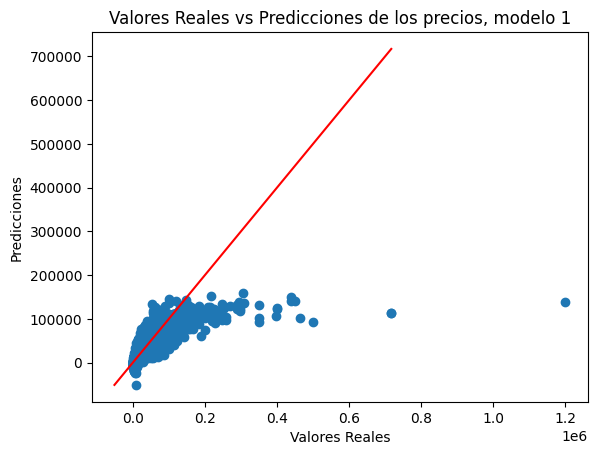

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(Y, Y1_pred)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Valores Reales vs Predicciones de los precios, modelo 1')
# Dibujar la línea de perfección
diagonal = np.linspace(min(Y_test.min(), Y_pred.min()), max(Y_test.max(), Y_pred.max()))
plt.plot(diagonal, diagonal, '-r')
plt.show()


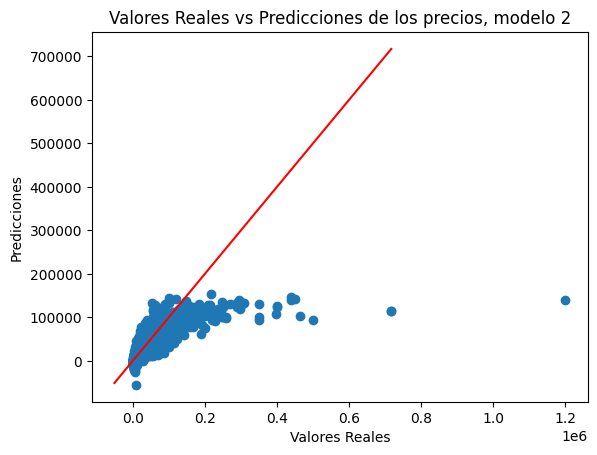

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(Y_without_semiautomatic, Y3_pred)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Valores Reales vs Predicciones de los precios, modelo 2')
# Dibujar la línea de perfección
diagonal = np.linspace(min(Y_test.min(), Y_pred.min()), max(Y_test.max(), Y_pred.max()))
plt.plot(diagonal, diagonal, '-r')
plt.show()

#Conclusiones
Luego de analizar los indicadores del modelo y de revisar gráfico de dispersión de valores reales vs predicciones, se concluye que un modelo de regresión lineal puede no ser el adecuado para hacer inferencia sobre este dataset.

Esto puede ser debido a la multicolinearidad, correlación entre las variables independientes o incluso al hecho de que a pesar de que exista relación entre las variables independientes elegidas y el precio, puede que esta sea no lineal, como lo es el caso de el kilometraje, que observamos que tiene una relación inversamente proporcional


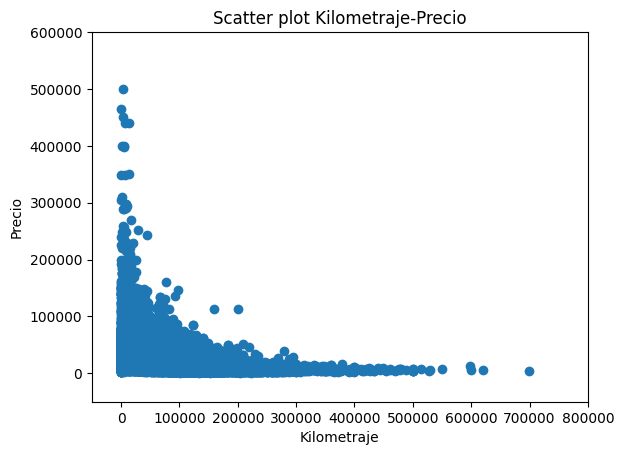

Para esto pueden realizarse transformaciones (1/x, log, etc), o contemplar la aplicación de otros modelos de regresión no lineal.

Otra consideración a tomar, es que en el modelo no se incluyeron la marca de los autos, ya que llevaría a la inclusión de muchas categorías, ya que hay muchos modelos de autos. Los modelos pueden llegar a ser significativos, ya que no es lo mismo un BMW que un Renault.

Para tratar esto, se podría incluir la categoría en el modelo de regresión lineal, o hacer un modelo de regresión lineal por cada marca de auto, enfocandose en las de mayor interés.


#Análisis exploratorios adicionales
Veamos para las variables categóricas nominales su distribución respecto al precio.

Text(0.5, 1.0, 'Boxplot agrupado offerType-Precio')

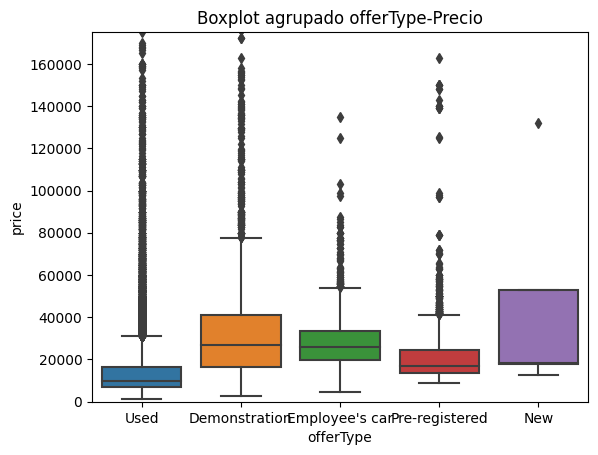

In [ ]:
#
sns.boxplot(x='offerType', y='price', data=data)
plt.ylim(0,175000)
plt.title('Boxplot agrupado offerType-Precio')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, 'Gasoline'),
  Text(1, 0, 'Diesel'),
  Text(2, 0, 'Electric/Gasoline'),
  Text(3, 0, 'Electric'),
  Text(4, 0, 'LPG'),
  Text(5, 0, 'CNG'),
  Text(6, 0, 'Others'),
  Text(7, 0, 'Electric/Diesel'),
  Text(8, 0, '-/- (Fuel)'),
  Text(9, 0, 'Ethanol'),
  Text(10, 0, 'Hydrogen')])

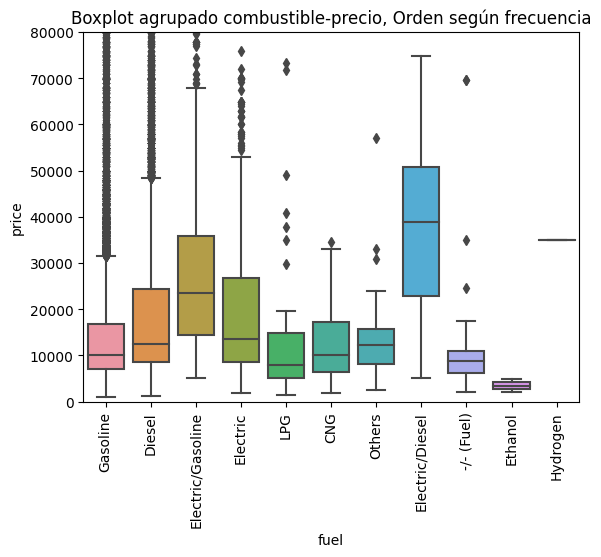

In [ ]:
# Crear una lista ordenada según frecuencia
fuel_count = data['fuel'].value_counts()
fuel_order = fuel_count.index.tolist()

sns.boxplot(x='fuel', y='price', data=data, order=fuel_order)
plt.ylim(0,80000)
plt.title('Boxplot agrupado combustible-precio, Orden según frecuencia')
plt.xticks(rotation=90)

(0.0, 150000.0)

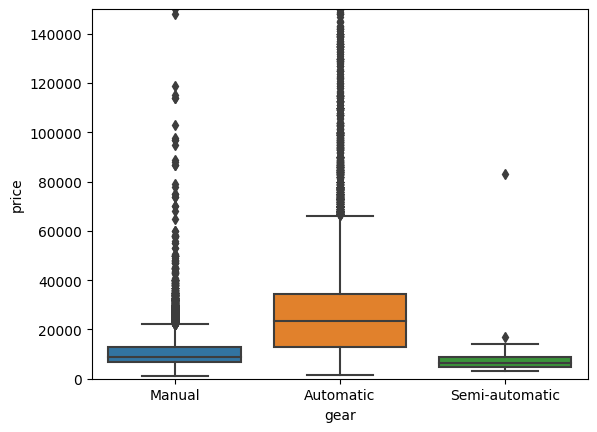

In [ ]:
sns.boxplot(x='gear', y='price', data=data)
plt.ylim(0,150000)
plt.title('Boxplot agrupado transmisión-precio')